# Looking behind the curtain of GPT!

You can simply scroll down to the diagram below to see the results.

If you'd like to try this yourself - this runs nicely on a free Colab CPU box.

## Setup instructions

### First get an OpenAI key if you don't already have one

1. Visit [OpenAI](https://platform.openai.com/) and create an API account as needed
2. On OpenAI's [billing](https://platform.openai.com/settings/organization/billing/overview) page, top up with the minimum amount to get started, typically $5 is the minimum
3. On OpenAI's [API key](https://platform.openai.com/settings/organization/api-keys) page, create an API key to use and keep it somewhere safe
4. Check that everything is working by visiting the [playground](https://platform.openai.com/playground/chat?models=gpt-4o-mini)

### Then set the key as a 'Secret' in this colab, which will be private for you

1. Press the key symbol in the left sidebar
2. Enter a Name of `OPENAI_API_KEY` and paste your actual key in
3. Ensure the switch for "Notebook access" is switched on.

## Then you're ready for showtime..

In [1]:
# first install the libraries for OpenAI and for the visualizer

!pip install -q openai networkx

In [2]:
# Get the api key from the secrets

from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')
if api_key.startswith("sk-proj-"):
  print("API key looks good so far")
else:
  print("Potential problem finding API key - please check setup instructions!")

API key looks good so far


In [3]:
# Check OpenAI connectivity with a not-so taxing question

from openai import OpenAI
openai = OpenAI(api_key=api_key)
response = openai.chat.completions.create(model="gpt-4o-mini", messages=[{"role": "user", "content": "What is 2+2?"}])
print(response.choices[0].message.content)

2 + 2 equals 4.


In [4]:
# Some imports

import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import json
import math

In [5]:
# A class to call OpenAI and return a list of dicts of predictions to display

class TokenPredictor:
    def __init__(self, client, model_name: str, temperature: int):
        self.client = client
        self.messages = []
        self.predictions = []
        self.model_name = model_name
        self.temperature = temperature

    def predict_tokens(self, prompt: str, max_tokens: int = 100) -> List[Dict]:
        """
        Generate text token by token and track prediction probabilities.
        Returns list of predictions with top token and alternatives.
        """
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens,
            temperature=self.temperature,
            logprobs=True,
            seed=42,
            top_logprobs=7,
            stream=True
        )

        predictions = []
        for chunk in response:
            if chunk.choices[0].delta.content:
                token = chunk.choices[0].delta.content
                logprobs = chunk.choices[0].logprobs.content[0].top_logprobs
                logprob_dict = {item.token: item.logprob for item in logprobs}

                # Get top predicted token and probability
                top_token = token
                top_prob = logprob_dict[token]

                # Get alternative predictions
                alternatives = []
                for alt_token, alt_prob in logprob_dict.items():
                    if alt_token != token:
                        alternatives.append((alt_token, math.exp(alt_prob)))
                alternatives.sort(key=lambda x: x[1], reverse=True)

                prediction = {'token': top_token, 'probability': math.exp(top_prob),'alternatives': alternatives[:2]}
                predictions.append(prediction)

        return predictions

In [6]:
# A function to create a directed graph based on the predictions

def create_token_graph(model_name:str, predictions: List[Dict]) -> nx.DiGraph:
    """
    Create a directed graph showing token predictions and alternatives.
    """
    G = nx.DiGraph()

    G.add_node("START", token=model_name, prob="START", color='lightgreen', size=4000)

    # First, create all main token nodes in sequence
    for i, pred in enumerate(predictions):
        token_id = f"t{i}"
        G.add_node(token_id, token=pred['token'], prob=f"{pred['probability']*100:.1f}%", color='lightblue', size=6000)
        G.add_edge(f"t{i-1}" if i else "START", token_id)

    # Then add alternative nodes with a different y-position
    last_id = None
    for i, pred in enumerate(predictions):
        parent_token = "START" if i == 0 else f"t{i-1}"

        # Add alternative token nodes slightly below main sequence
        for j, (alt_token, alt_prob) in enumerate(pred['alternatives']):
            alt_id = f"t{i}_alt{j}"
            G.add_node(alt_id, token=alt_token, prob=f"{alt_prob*100:.1f}%", color='lightgray', size=6000)
            G.add_edge(parent_token, alt_id)

    G.add_node("END", token="END", prob="100%", color='red', size=6000)
    G.add_edge(parent_token, "END")
    return G

In [7]:
# Visualize the graph using Matplotlib

def visualize_predictions(G: nx.DiGraph, figsize=(14, 150)):
    """
    Visualize the token prediction graph with vertical layout and alternating alternatives.
    """
    plt.figure(figsize=figsize)

    pos = {}
    spacing_y = 10
    spacing_x = 5

    # Position main token nodes in a vertical line
    main_nodes = [n for n in G.nodes() if '_alt' not in n]
    for i, node in enumerate(main_nodes):
        pos[node] = (0, -i * spacing_y)  # Center main tokens vertically

    # Position alternative nodes to left and right of main tokens
    for node in G.nodes():
        if '_alt' in node:
            main_token = node.split('_')[0]
            alt_num = int(node.split('_alt')[1])
            if main_token in pos:
                # Place first alternative to left, second to right
                x_offset = spacing_x if alt_num else -spacing_x
                pos[node] = (x_offset, pos[main_token][1] + 0.05)

    # Draw nodes
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    node_sizes = [G.nodes[node]['size'] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)

    # Draw all edges as straight lines
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, alpha=0.7)

    # Add labels with token and probability
    labels = {node: f"{G.nodes[node]['token']}\n{G.nodes[node]['prob']}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=14)

    plt.title("How would you describe the color blue to someone who has never been able to see, in no more than 3 sentences.")
    plt.axis('off')

    # Adjust plot limits to ensure all nodes are visible, then show!
    margin = 8
    x_values = [x for x, y in pos.values()]
    y_values = [y for x, y in pos.values()]
    plt.xlim(min(x_values) - margin, max(x_values) + margin)
    plt.ylim(min(y_values) - margin, max(y_values) + margin)
    plt.show()

## Just before showtime - some essential resources!

- [Connect with me](https://www.linkedin.com/in/eddonner/) on LinkedIn - I love connecting
- [Follow me](https://x.com/edwarddonner) on X
- [See my other videos](https://www.youtube.com/@Edward.Donner) on YouTube
- And most of all: consider my intensive 8 week training course to [Master LLM engineering](https://www.udemy.com/course/llm-engineering-master-ai-and-large-language-models/?referralCode=35EB41EBB11DD247CF54)!

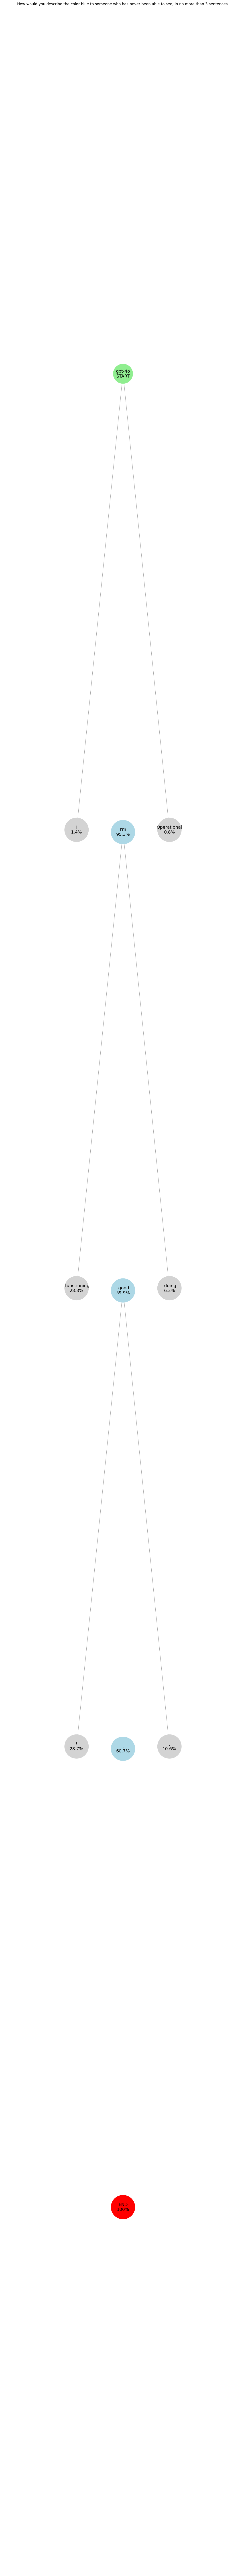

In [8]:
# And now, pick a model and run!

# For advanced experimenters: try changing temperature to a higher number like 0.4
# A higher temperature means that occasionally a token other than the one with the highest probability will be picked
# Resulting in a more diverse output

model_name = "gpt-4o"
temperature = 0.0

predictor = TokenPredictor(openai, model_name, temperature)
#prompt = "How would you describe the color blue to someone who has never been able to see, in no more than 3 sentences."
prompt = "How would you describe the color blue to someone who has never been able to see, in no more than 3 sentences."
predictions = predictor.predict_tokens(prompt)
G = create_token_graph(model_name, predictions)
visualize_predictions(G)